# Auditing Allocative Bias

---

### What is the purpose of this blog post?

In this blog post, we aim to create a machine learning model that predicts whether a person's income is over $50k using their demographic data, excluding sex. Once we have a working model, we will perform a fairness audit in order to assess whether or not the algorithm displays bias for demographic characteristics like sex.

---

### Libraries and Modules

Before starting, you'll want to import the following libraries and modules. We'll also be using the `folktables` package to download and organize data from the American Community Survey's Public Use Microdata Sample (PUMS).

In [64]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import seasborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt


---

### Data Preparation

First thing we want to do is get the data for the state that we want to work with. The state we'll be working with in this blog post is Mississippi (MS) because it has the one of the highest [poverty rates](https://www.census.gov/library/stories/2023/02/state-official-poverty-rates-changed-over-10-years.html#:~:text=Mississippi%20had%20among%20the%20highest,average%20poverty%20rate%20(7.3%25)) in the country. However, any state would work as well. We add a column at the end of the data frame to indicate whether the indiviual has an income of over 50k.

In [69]:
STATE = "MS"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

#add column to indicate whether an individual is employed
acs_data = acs_data.assign(S50K = 1 * (acs_data['PINCP'] > 50000)) 

acs_data.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80,S50K
0,P,2018GQ0000052,6,1,1700,3,28,1013097,42,51,...,80,76,81,79,43,44,80,78,5,0
1,P,2018GQ0000125,6,1,1100,3,28,1013097,50,64,...,45,43,77,39,6,8,6,50,6,0
2,P,2018GQ0000187,6,1,300,3,28,1013097,11,93,...,0,12,0,25,12,0,3,14,12,0
3,P,2018GQ0000190,6,1,600,3,28,1013097,38,68,...,46,41,39,39,72,41,3,73,73,0
4,P,2018GQ0000204,6,1,1300,3,28,1013097,21,34,...,4,4,37,19,2,40,39,22,20,0


As you can see from the data above, there are over 280 features that we can work with. 280 features are a lot, so we will be focusing on the features below:

`AGEP`: Age

`COW`: Class of worker

`SCHL`: Educational attainment

`MAR`: Marital status

`OCCP`: Occupation

`POBP`: Place of birth

`RELP`: Relationship

`WKHP`: Usual hours worked per week past 12 months

`RAC1P`: Recoded detailed race code

`DIS`: Disability recode

`CIT`: Citizenship status

`MIG`: Mobility status (lived here 1 year ago)

`MIL`: Military service

`DEAR`: Hearing difficulty

`DEYE`: Vision difficulty

`DREM`: Cognitive difficulty

`ESR`: Employment status recode

In [2]:
p_feat = ['AGEP', 'COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'WKHP', 'RAC1P', 'DIS', 'MIG', 'CIT', 'MIL', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'PINCP', 'S50K']
acs_data[p_feat].head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,RAC1P,DIS,MIG,CIT,MIL,NATIVITY,DEAR,DEYE,DREM,SEX,PINCP,S50K
0,51,1.0,20.0,3,4760.0,28,16,NaN,2,1,1.0,1,4.0,1,2,2,2.0,1,0.0,0
1,64,NaN,16.0,3,NaN,28,17,NaN,1,1,1.0,1,4.0,1,2,2,1.0,1,15000.0,0
2,93,NaN,5.0,2,NaN,28,16,NaN,2,1,1.0,1,4.0,1,2,2,2.0,1,6700.0,0
3,68,NaN,1.0,5,NaN,28,16,NaN,1,1,1.0,1,4.0,1,2,2,1.0,1,5800.0,0
4,34,NaN,1.0,5,NaN,28,17,NaN,2,1,1.0,1,4.0,1,2,2,1.0,1,530.0,0


We will not include `SEX`, `PINCP`, and `S50K`, since our group choice is sex (we will evaluate bias against) and salary is our target variable.

In [4]:
features_to_use = [f for f in p_feat if f not in ['SEX', 'PINCP', 'S50K']]

Now that we have our features, we will construct a `BasicProblem` that will allow us to use these features to predict whether an individual makes over 50k. `SEX` will be our group label, and `S50K` will be our target.

In [5]:
SalaryProblem = BasicProblem(
    features=features_to_use,
    target='S50K',
    target_transform=lambda x: x == 1,
    group='SEX',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = SalaryProblem.df_to_numpy(acs_data)

The result is a feature matrix `features` in a format that we can work with

In [6]:
for obj in [features, label, group]:
  print(obj.shape)

(29124, 17)
(29124,)
(29124,)


We now want to split the data using `train_test_split`.

In [70]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

---

### Basic Descriptives

We will use simple descriptive analysis to learn more about our data. We first want to inspect how many individuals we'll be working with.

In [73]:
df = pd.DataFrame(X_train, columns = features_to_use)
df['SEX'] = group_train
df['>50k'] = y_train

df.shape

(23299, 19)

Based on the dimensions of our data frame, we will have 23299 individuals. We then want to figure out the proportion of individuals who have an income of over 50k.

In [17]:
over_50k = df.groupby(['>50k']).size().reset_index(name = 'count')
over_50k['%'] = (over_50k['count'] / len(df.index) * 100).round(2)

over_50k    

,>50k,count,%
0,False,19955,85.65
1,True,3344,14.35


Here we can see that only 3,344 people out of 23,299 in Mississippi (14.35%) have an income over 50k. Next, we want to inspect how many of this 14.35% are males and how many are females.

In [23]:
f_df = df[df['>50k'] == True]

over_50k_s = f_df.groupby(['SEX']).size().reset_index(name = 'count')
over_50k_s['%'] = ((over_50k_s['count'] / len(f_df.index)) * 100).round(2)

over_50k_s

,SEX,count,%
0,1,2213,66.18
1,2,1131,33.82


From our data frame, we learn that of the 14.35% who are making over 50k, about 66.18% of them are males while 33.82% are females. Next, we want to look at the separate sex groups-- we want to find out the proportion of males who are making over 50k, and the proportion of females who are making over 50k.

In [21]:
f_df = df[df['SEX'] == 1]

male = f_df.groupby(['>50k']).size().reset_index(name = 'count')
male['percent'] = ((male['count'] / len(f_df.index)) * 100).round(2)

male

,>50k,count,percent
0,False,8857,80.01
1,True,2213,19.99


The table above is of the male group. About 20% of males make over 50k.

In [25]:
f_df = df[df['SEX'] == 2]

female = f_df.groupby(['>50k']).size().reset_index(name = 'count')
female['percent'] = ((female['count'] / len(f_df.index)) * 100).round(2)

female

,>50k,count,percent
0,False,11098,90.75
1,True,1131,9.25


The table above is of the female group. About 9.25% of females make over 50k. We will also check for intersectional trends by computing the proportion of positive labels by both sex and race.

In [74]:
f_df = df[df['>50k'] == 1]

inter = f_df.groupby(['SEX', 'RAC1P']).size().reset_index(name = 'count')
inter['%'] = ((inter['count'] / len(f_df.index)) * 100).round(2)

inter


,SEX,RAC1P,count,%
0,1,1.0,1811,54.16
1,1,2.0,335,10.02
2,1,3.0,6,0.18
3,1,6.0,26,0.78
4,1,8.0,13,0.39
5,1,9.0,22,0.66
6,2,1.0,872,26.08
7,2,2.0,232,6.94
8,2,3.0,1,0.03
9,2,6.0,15,0.45


[Text(0.5, 1.0, 'Percentage of People with Income >50k by Sex and Race')]

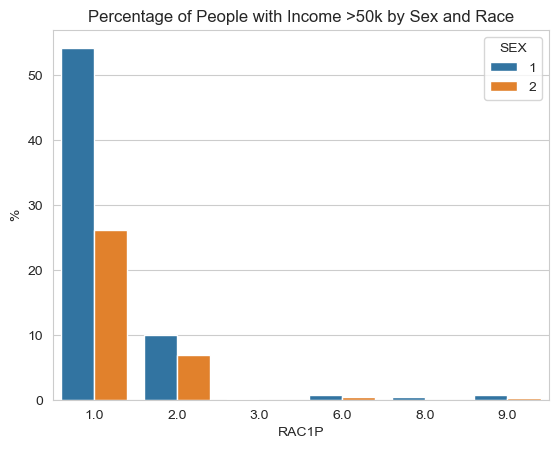

In [75]:
sns.set_style('whitegrid')
sns.barplot(x = 'RAC1P', y = '%', hue = 'SEX', data = inter).set(title = 'Percentage of People with Income >50k by Sex and Race')

We created a table and a bar plot to visualize the percentage of people with income of over 50k grouped by their sex and race. Based on the graph, we can see that over 50% of white males make more than 50k. This is followed by white females, black or African American males, and black or African American females.

---

### Train Our Model

For our model, we'll be using `DecisionTreeClassifier`. Since this model requires a specified `max_depth`, we will use cross validation to find it. After finding the `max_depth`, we will use it to create our model.

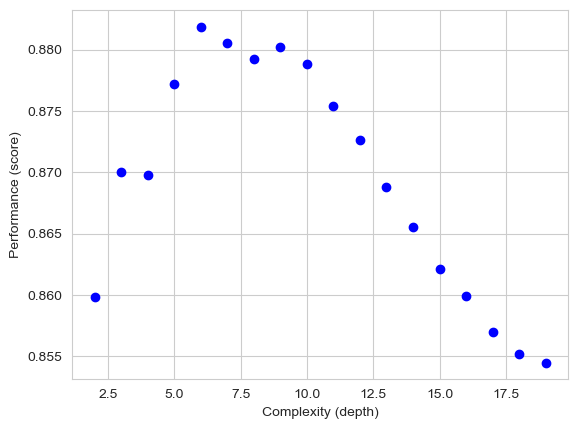

In [95]:
plt.figure()

max_score = 0
best_depth = 0
for d in range(2, 20):
    T = DecisionTreeClassifier(max_depth=d)
    cv_mean = cross_val_score(T, X_train, y_train, cv=10).mean()
    plt.plot(d, cv_mean, 'bo')
    if cv_mean > max_score:
        max_score = cv_mean
        best_depth = d

plt.xlabel('Complexity (depth)')
plt.ylabel('Performance (score)')
plt.show()

In [98]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

dt = DecisionTreeClassifier(max_depth = best_depth)
model = make_pipeline(StandardScaler(), dt)

model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=6))])

We will define a function that'll compute the positive predictive values (PPV), false negative rate (FNR), and false positive rate (FPR).

In [99]:
def PPV_FNR_FPR(data, predictions):
    confusion = confusion_matrix(data, predictions)
    TP = confusion[1][1]
    TN = confusion[0][0]
    FP = confusion[0][1]
    FN = confusion[1][0]
    PPV = TP / (TP + FP)
    print(f"{PPV=}")
    FNR = FN / (FN + TP)
    print(f"{FNR=}")
    FPR = FP / (FP + TN)
    print(f"{FPR=}")

In [100]:
y_hat = model.predict(X_test)

---

### Audit Our Model

We want to perform an audit to address the overall measures:

    1. What is the overall accuracy of our model?
    2. What is the positive predictive value (PPV) of our model?
    3. What are the overall false negative and false positive rates (FNR and FPR) of our model?
    
as well as the by-group measures:

    1. What is the accuracy of our model on each subgroup?
    2. What is the PPV of our model on each subgroup?
    3. What are the FNR and FPR on each subgroup?

In [102]:
# Overall accuracy
(y_hat == y_test).mean()

0.8817167381974249

In [103]:
# PPV, FNR, and FPR (overall)
PPV_FNR_FPR(y_test, y_hat)

PPV=0.6381818181818182
FNR=0.582639714625446
FPR=0.03992776886035313


In [104]:
# Accuracy for male group
(y_hat == y_test)[group_test == 1].mean()

0.8524822695035461

In [105]:
# PPV, FNR, and FPR for male group
PPV_FNR_FPR(y_test[group_test == 1], y_hat[group_test == 1])

PPV=0.7366666666666667
FNR=0.6039426523297491
FPR=0.034924845269672856


In [108]:
# Acuracy for female group
(y_hat == y_test)[group_test == 2].mean()

0.9091514143094842

In [109]:
# PPV, FNR, and FPR for female group
PPV_FNR_FPR(y_test[group_test == 2], y_hat[group_test == 2])

PPV=0.52
FNR=0.5406360424028268
FPR=0.0440852314474651


It does not seem like our model is calibrated because the PPV is not consistent across the different groups. It also seems like the model does not satify approximate error rate balance because of the big difference between FNR and FPR. It seems that for all groups, the model is prioritzing the minimization of false positives over false negatives. Our model also doesn't satisfy the statistical parity because of the differences in PPV, FNR, and FPR across all groups.

---

### Concluding Discussion

This model could potentially benefit researchers and sociologists who are studying income inequality, social mobility, or demographic patterns as they can get insights into the relationship between demographics and income. Financial institutions (e.g. banks, lenders, etc.) and different governments can also potentially benefit from this as they can use it to assess credit worthiness and make decisions regarding loan approvals, interest rates, or financial services. 

However, this could affect other people's quality lives. For this model specifically, the FNR for all three groups (overall, male, and females) is around 0.57, which is relatively high. This also indicates that the model is incorrectly predicting postive as negative. This could lead to those who don't really need extra financial assistance to be falsely classified as needing the assistance, taking the opportunity away from those actually in need. 

On a similar note, the model does display problematic bias considering that it failed to satisfy approximate error rate balance and statistical parity. It is also not calibrated. Using the example above, the FNR for the male group is higher than the female group. This could result in someone from the male group getting the extra financial assistance when they may not need it as much compared to someone from the female group (higher FPR than the male group -- incorrectly classifying them as having a higher income than they may have).

Beside bias, a model like this is also concerning because of the data behind it. This model predicts a person's income based on their demographics, which means that it may involve making inferences about an individual's financial situation without their explicit consent or knowledge. Another point is that this model uses about 17 features, however there are more factors that can influence a person's income. By not including those other factors, this model would not accurately predict an individual's income. A possible way to address these problems would be a more robust data collection process that involves consent. In addition to that, we'd need to make sure the data is comprehensive and diverse, covering a wide range of factors that influence income, including both demographic and non-demographic variables.